## Using ControlNet for brain mask-conditioned generation

### 0. Imports and arguments

In [1]:
# Copyright (c) MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [1]:
!python -c "import monai" || pip install -q "monai-weekly[tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

In [24]:
import numpy as np
import os
import tempfile
import nibabel as nib
import monai
from monai.utils import first, set_determinism
from generative.networks.nets.controlnet import ControlNet
from monai.bundle.config_parser import ConfigParser
import torch
from tqdm import tqdm
from generative.networks.schedulers import DDPMScheduler, DDIMScheduler
from copy import deepcopy
import gdown
import zipfile
import yaml
from pathlib import Path

In [3]:
set_determinism(35) 

In [4]:
 # Arguments
val_perc = 0.2
batch_size = 8
num_workers = 2
input_shape = [160, 224, 160]
path_to_bundle = ""
lr = 0.00002
validation_epochs = 5
saving_epochs = 1
scale_factor = 1.0
num_epochs = 100

### 1. Setting up the temporary directory and the dataloading

In [5]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
root_dir = Path(root_dir)
print("Temporary directory used: %s " %root_dir)

Temporary directory used: /tmp/tmp8r8zt1ux 


In [6]:
gdown.download("https://drive.google.com/uc?export=download&id=1XFXBsgVuYV3d6LmzNRsxrAr_UKb7v6WT", 
               str(root_dir / 'data.zip'))

Downloading...
From: https://drive.google.com/uc?export=download&id=1XFXBsgVuYV3d6LmzNRsxrAr_UKb7v6WT
To: /tmp/tmp8r8zt1ux/data.zip
100%|██████████████████████████████████████████████████████████████████████████████| 707M/707M [00:09<00:00, 76.6MB/s]


'/tmp/tmp8r8zt1ux/data.zip'

In [7]:
zip_obj = zipfile.ZipFile(os.path.join(root_dir, 'data.zip'), 'r')
zip_obj.extractall(root_dir)
path_to_image_files = root_dir / 'BRAIN_T1_UKB_LDM' / 'images'
path_to_label_files = root_dir / 'BRAIN_T1_UKB_LDM' / 'labels'

### 2. Auxiliary functions

In [8]:
# We define some functions that we will use later.

In [9]:
def get_loader(path_to_image_files, path_to_label_files, input_shape = [160, 224, 160], val_perc = 0.20, batch_size = 8,
               num_workers = 2):
    '''
    Gets train and validation loaders
    Args:
        path_to_image_files: path to the images
        path_to_label_files: path to the brain labels
        input_shape: 3D spatial shape (list)
        val_perc: percentage of the images that go to the validation loader
        batch_size: 
        num_workers: 
    '''

    all_images = os.listdir(path_to_image_files)
    val_files = [{'image': os.path.join(path_to_image_files, f),
                  'label': os.path.join(path_to_label_files, f),
                  'gender': float(f.strip(".nii.gz").split("_")[-4]),
                  'age': float(f.strip(".nii.gz").split("_")[-3]),
                  'ventricular_vol': float(f.strip(".nii.gz").split("_")[-2]),
                  'brain_vol': float(f.strip(".nii.gz").split("_")[-1]),} for f in all_images[:int(val_perc * len(all_images))]]
    train_files = [{'image': os.path.join(path_to_image_files, f),
                    'label': os.path.join(path_to_label_files, f),
                    'gender': float(f.strip(".nii.gz").split("_")[-4]),
                    'age': float(f.strip(".nii.gz").split("_")[-3]),
                    'ventricular_vol': float(f.strip(".nii.gz").split("_")[-2]),
                    'brain_vol': float(f.strip(".nii.gz").split("_")[-1]),
                    } for f in all_images[int(val_perc * len(all_images)):]]

    train_transforms = monai.transforms.Compose(
        [monai.transforms.LoadImaged(keys = ['image', 'label']),
         monai.transforms.EnsureChannelFirstd(keys = ['image', 'label']),
         monai.transforms.CenterSpatialCropd(keys = ['image', 'label'], roi_size=input_shape),
         monai.transforms.SpatialPadd(keys=['image', 'label'], spatial_size=input_shape,),
         monai.transforms.EnsureTyped(keys=["image", "label"]),
         monai.transforms.Orientationd(keys=["image", 'label'], axcodes="RAS"),
         monai.transforms.ScaleIntensityRangePercentilesd(keys="image", lower=0, upper=99.5, b_min=0, b_max=1),
         monai.transforms.ToTensord(keys=['image', 'label', 'gender', 'age', 'ventricular_vol', 'brain_vol']),
                                    ]
    )
    #monai.transforms.MaskIntensityd(keys=['image'], mask_key='label'),
    train_dataset = monai.data.Dataset(data=train_files, transform = train_transforms)
    val_dataset = monai.data.Dataset(data=val_files, transform=train_transforms)
    train_loader = monai.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True,
                                         num_workers=num_workers)
    val_loader = monai.data.DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=True,
                                       num_workers=num_workers)
    return train_loader, val_loader

In [10]:
def load_model_from_bundle(bundle_path):
    '''
    From the bundle path of the model zoo, loads the model.
    Args:
        bundle_path: path to the directory of the model zoo containing the model and the configuration yaml or json files.
    Returns:
    '''
    # If the models aren't downloaded, we manually download them from the large_files link. 
    with open("%s/large_files.yml" %bundle_path, "r") as stream:
        large_files_paths = yaml.safe_load(stream)
    if not os.path.isfile(os.path.join(bundle_path, 'models', 'autoencoder.pth')):
        gdown.download(large_files_paths['large_files'][0]['url'], 
                       os.path.join(bundle_path, ['large_files'][0]['path']))
    if not os.path.isfile(os.path.join(bundle_path, 'models', 'diffusion_model.pth')):
        gdown.download(large_files_paths['large_files'][1]['url'], 
                       os.path.join(bundle_path, ['large_files'][1]['path']))
    # We extract the configs for the bundle directory and load it into the models. 
    cp = ConfigParser()
    bundle_root = bundle_path
    cp.read_meta(f"{bundle_root}/configs/metadata.json")
    cp.read_config(f"{bundle_root}/configs/inference.json")
    cp["bundle_root"] = bundle_root
    autoencoder = cp.get_parsed_content("autoencoder_def")
    autoencoder.load_state_dict(torch.load(os.path.join(bundle_path, 'models', 'autoencoder.pth')))
    diffusion = cp.get_parsed_content("diffusion_def")
    diffusion.load_state_dict(torch.load(os.path.join(bundle_path, 'models', 'diffusion_model.pth')))
    return autoencoder, diffusion

In [11]:
def create_mask(data, input_shape):
    '''
    From the conditioning gender, age, ventricular volume and brain volume values,
    creates a mask of the same spatial size as the latents to be concatenated to the
    latent representation during training of the DM.
    Args:
        data: data dictionary from the data loader
        input_shape: 3D spatial shape
    Returns:
    '''
    input_mask = torch.ones([data['image'].shape[0]] + [4] + input_shape[2:])
    for b in range(input_mask.shape[0]):
        input_mask[b, 0, :] *= data['gender'][b]
        input_mask[b, 1, :] *= data['age'][b]
        input_mask[b, 2, :] *= data['ventricular_vol'][b]
        input_mask[b, 3, :] *= data['brain_vol'][b]
    return input_mask

### 3. Get the original LDM from the MONAI Model Zoo and initialise ControlNet

ControlNet is based on the weights of the LDM we want to control. In this case we download the brain T1 MR model from the model-zoo (https://github.com/Project-MONAI/GenerativeModels/tree/main/model-zoo/models/brain_image_synthesis_latent_diffusion_model). We'll need to freeze the weights of this model as we do not want to train it. We'll copy the weights into the ControlNet. 

In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"
path_to_bundle = "../../../model-zoo/models/brain_image_synthesis_latent_diffusion_model"
autoencoder = os.path.join(path_to_bundle, "models", "autoencoder.pth")
ldm = os.path.join(path_to_bundle, "models", "diffusion_model.pth")
# If the models aren't there we download them

# Create checkpoint
sample_dir = root_dir / 'samples_dir'
sample_dir.mkdir(exist_ok=True)
# Load diffusion model
autoencoder, diffusion = load_model_from_bundle(path_to_bundle)
# Create control net
controlnet = ControlNet(spatial_dims=3, in_channels=7,
                        num_res_blocks=diffusion.num_res_blocks,
                        num_channels=diffusion.block_out_channels, with_conditioning=False,
                        attention_levels=diffusion.attention_levels,
                        )
# Copy weights from the DM to the controlnet
controlnet.load_state_dict(diffusion.state_dict(), strict = False)
controlnet = controlnet.to(device)
# Now, we freeze the parameters of the diffusion model. 
for p in autoencoder.parameters():
    p.requires_grad = False # Freeze weights
for p in diffusion.parameters():
    p.requires_grad = False # Freeze weights
autoencoder = autoencoder.to(device)
diffusion = diffusion.to(device)

### 4. Create the objects for training

In [13]:
# Training and validation data loaders
train_loader, val_loader = get_loader(path_to_image_files, path_to_label_files, input_shape,
                                      val_perc, batch_size, num_workers)
# DDPM scheduler
scheduler = DDPMScheduler(num_train_timesteps=1000,
                               beta_schedule = 'scaled_linear',
                               beta_start=0.0015,
                               beta_end= 0.0205,
                               clip_sample=False,)
# Optimizer
optimizer = torch.optim.Adam(params = controlnet.parameters(), lr = lr, betas = (0.9, 0.99))

## Sanity check: models work as expected before any training done

100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:11<00:00,  4.38it/s]


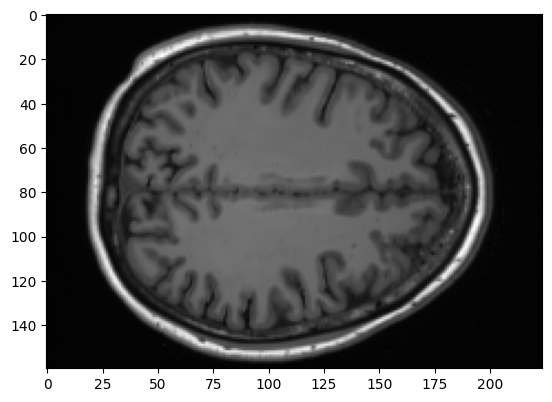

In [51]:
# sanity check the loaded models - do they produce sensible results?
from torch.cuda.amp import autocast
import matplotlib.pyplot as plt


conditioning = torch.tensor([[0.0, 0.1, 0.2, 0.4]]).to(device).unsqueeze(1)
input_noise = torch.randn((1, 3, 20, 28, 20)).to(device)
# use ddim for faster sampling
scheduler_ddim = DDIMScheduler(num_train_timesteps=1000,
                               beta_schedule = 'scaled_linear',
                               beta_start=0.0015,
                               beta_end= 0.0205,
                               clip_sample=False,)
scheduler_ddim.set_timesteps(50)
progress_bar = tqdm(scheduler_ddim.timesteps)

# here we just check the trained diffusion model
image = input_noise
cond_concat = conditioning.squeeze(1).unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
cond_concat = cond_concat.expand(list(cond_concat.shape[0:2]) + list(input_noise.shape[2:]))
for t in progress_bar:
    with torch.no_grad():
        model_output = diffusion(
            torch.cat((image, cond_concat), dim=1),
            timesteps=torch.Tensor((t,)).to(input_noise.device).long(),
            context=conditioning,
        )
        image, _ = scheduler_ddim.step(model_output, t, image)
with torch.no_grad():
    with autocast():
        sample = autoencoder.decode_stage_2_outputs(image)

plt.imshow(sample[0,0,:,:,90].cpu(), cmap='gray')

100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.93it/s]


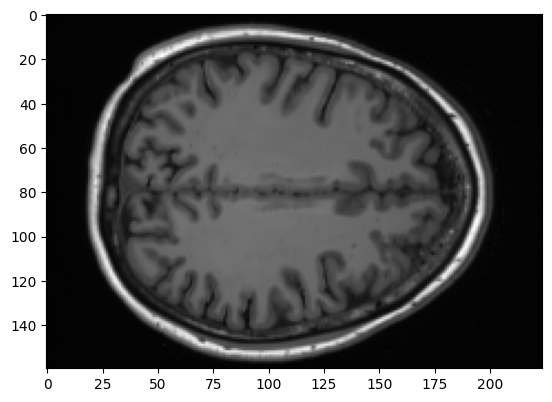

In [53]:
# now we check the trained diffusion model with controlnet outputs - before controlnet is trained, samples should be unchanged
batch = train_loader.dataset[0]
image, label = batch['image'], batch['label']

image = input_noise
cond_concat = conditioning.squeeze(1).unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
cond_concat = cond_concat.expand(list(cond_concat.shape[0:2]) + list(input_noise.shape[2:]))

progress_bar = tqdm(scheduler_ddim.timesteps)
for t in progress_bar:
    with torch.no_grad():
        down_block_res_samples, mid_block_res_sample = controlnet(
            torch.cat((image, cond_concat), dim=1),
            timesteps=torch.Tensor((t,)).to(input_noise.device).long(),
            controlnet_cond = label.to(device),
            context = None,
        )
        model_output = diffusion(
            torch.cat((image, cond_concat), dim=1),
            timesteps=torch.Tensor((t,)).to(input_noise.device).long(),
            context=conditioning,
            down_block_additional_residuals = down_block_res_samples,
            mid_block_additional_residual = mid_block_res_sample
        )
        image, _ = scheduler_ddim.step(model_output, t, image)
with torch.no_grad():
    with autocast():
        sample2 = autoencoder.decode_stage_2_outputs(image)

plt.imshow(sample2[0,0,:,:,90].cpu(), cmap='gray')

### 5. Training / validation loop

In [ ]:
best_val_loss = 1000
i_e = 0
for e in range(i_e, num_epochs):
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), ncols=110)
    progress_bar.set_description(f"Epoch {e}")
    epoch_loss = 0.0
    for step, data in progress_bar:
        input_conditioning = data['label'].to(device)
        input_image = data['image'].to(device)
        with torch.no_grad():
            # Obtain latent representation of the VAE
            latent = autoencoder.encode_stage_2_inputs(input_image) * scale_factor
        # We concatenate gender, age, ventricular volume and brain volume as additional channels
        input_mask = create_mask(data, list(latent.shape)).to(device)
        latent = torch.cat([latent, input_mask], dim = 1, )
        # Sample time steps and add noise to the latent space representation
        timesteps = torch.randint(0, scheduler.num_train_timesteps,(latent.shape[0],), device=device).long()
        noise = torch.randn(list(latent.shape)).to(device)
        noisy_latents = scheduler.add_noise(original_samples=latent, noise=noise, timesteps=timesteps)
        # Optimise
        optimizer.zero_grad()
        down_block_res_samples, mid_block_res_sample = controlnet(
            noisy_latents,
            timesteps,
            controlnet_cond = input_conditioning,
            context = None,
        )
        cond = torch.cat([data['gender'].unsqueeze(0),
                          data['age'].unsqueeze(0),
                          data['ventricular_vol'].unsqueeze(0),
                          data['brain_vol'].unsqueeze(0)], dim = 1).unsqueeze(1)
        prediction = diffusion(x=noisy_latents,
                               timesteps=timesteps,
                               context=cond.to(device),
                               down_block_additional_residuals = down_block_res_samples,
                               mid_block_additional_residual = mid_block_res_sample)
        loss = torch.nn.functional.l1_loss(prediction, noise[:, :3, ...])
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        progress_bar.set_postfix({"loss": epoch_loss / (step + 1)})

    # If validation is requested in this epoch: 
    if step % validation_epochs == 0:
        # Validation will consist on similar set-up than training: one denoising step > loss. 
        # In ONE occasion, we also perform a sampling. 
        sampling_step = np.random.randint(len(val_loader))
        val_loss = 0.0
        for ind, data in enumerate(val_loader):
            with torch.no_grad():
                diffusion = diffusion.eval()
                controlnet = controlnet.eval()
                input_conditioning = data['label'].to(device)
                input_image = data['image'].to(device)
                # Latent space representation of autoencoder
                latent = autoencoder.encode_stage_2_inputs(input_image) * scale_factor
                # We concatenate gender, age, ventricular volume and brain volume as additional channels
                input_mask = create_mask(data, list(latent.shape)).to(device)
                latent = torch.cat([latent, input_mask], dim=1, )
                # Sample time step and optimise 
                timesteps = torch.randint(0, scheduler.num_train_timesteps, (latent.shape[0],),
                                          device=device).long()
                noise = torch.randn(list(latent.shape)).to(device)
                noisy_latents = scheduler.add_noise(original_samples=latent, noise=noise, timesteps=timesteps)
                down_block_res_samples, mid_block_res_sample = controlnet(
                    noisy_latents,
                    timesteps,
                    controlnet_cond=input_conditioning,
                    context=None,
                )
                cond = torch.cat([data['gender'].unsqueeze(0),
                                  data['age'].unsqueeze(0),
                                  data['ventricular_vol'].unsqueeze(0),
                                  data['brain_vol'].unsqueeze(0)], dim=1).unsqueeze(1)
                prediction = diffusion(x=noisy_latents,
                                       timesteps=timesteps,
                                       context=cond.to(device),
                                       down_block_additional_residuals=down_block_res_samples,
                                       mid_block_additional_residual=mid_block_res_sample)
                val_loss += torch.nn.functional.l1_loss(prediction, noise[:, :3, ...]).item()

                if ind == sampling_step:
                    # If we need to sample
                    noise = torch.randn(list(noisy_latents.shape))
                    noise_pred = deepcopy(noise).to(device)
                    progress_bar_sampling = tqdm(scheduler.timesteps, total=len(scheduler.timesteps), ncols=110)
                    progress_bar_sampling.set_description("sampling...")
                    for t in progress_bar_sampling:
                        down_block_res_samples, mid_block_res_sample = controlnet(noise_pred,
                                                                              timesteps,
                                                                              controlnet_cond=input_conditioning)
                        noise_pred = diffusion(
                            noise_pred,
                            timesteps=torch.Tensor((t,)).to(device),
                            context=cond.to(device),
                            down_block_additional_residuals=down_block_res_samples,
                            mid_block_additional_residual=mid_block_res_sample)
                        noise_pred = torch.cat([noise_pred, input_mask], 1)
                    decoded = autoencoder.decode_stage_2_outputs(noise_pred[:, :3, ...]).detach().cpu()
                    # Log image
                    # We make a 2 x 2 grid with: GT / Predicted / Mask
                    input_conditioning = input_conditioning.detach().cpu().squeeze(1) # Remove channel
                    input_image = input_image.detach().cpu().squeeze(1) # Remove channel
                    for b in range(input_conditioning.shape[0]):
                        to_save = torch.cat([input_image[b, ...], decoded[b, 0,...]], 1)
                        to_save = torch.cat([to_save, torch.cat([input_conditioning[b, ...],
                                                                torch.zeros_like(input_conditioning[b, ...])],
                                                                1),
                                             ],0)
                        to_save = to_save.numpy()
                        nifti_image = nib.Nifti1Image(to_save, affine = np.eye(4))
                        nib.save(nifti_image, os.path.join(root_dir, 'samples_dir', "val_epoch_%d_%d.nii.gz" %(e, b)))
        val_loss = val_loss / len(val_loader)
        print("Validation loss epoch %d: %.3f" %(e, val_loss))
        controlnet.train()
        diffusion.train()
print("Training finished...")